# Process B16F10 10x data

## Purpose

This notebook processes 10x scRNA-seq data from a lineage tracing experiment. It calls clones based on shared target sites and identifies doublet and low quality cells. It also processes target site reads, filtering out alleles with insufficient coverage, removing target sites with multiple integrations, and finally assigning a unique target site allele to each cell.

## Setup

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import petracer
import scanpy as sc
import seaborn as sns
from petracer.config import colors, discrete_cmap, sequential_cmap, site_names
from petracer.seq import select_allele, sigma_threshold

site_names = list(site_names.keys())

base_path, data_path, plot_path, results_path = petracer.config.get_paths("kinetics")
petracer.config.set_theme()
np.random.seed(42)

%load_ext autoreload
%autoreload 2

## Load data

Specify samples and names

In [5]:
samples = {"B16F10_D4_rep1":"D4_1",
           "B16F10_D6_rep1":"D6_1",
           "B16F10_D10_rep1":"D10_1",
           "B16F10_D14_rep1":"D14_1",
           "B16F10_D21_rep1":"D21_1",
           "B16F10_D28_rep1":"D28_1",
           "B16F10_D28_rep2":"D28_2"}

Transciptome

In [ ]:
adata = []
for sample, name in samples.items():
    adata_sample = sc.read_10x_h5(data_path / sample / f"{sample}_filtered_counts.h5")   
    adata_sample.var_names_make_unique()  
    adata.append(adata_sample)
adata = ad.concat(adata, join='outer',label = "sample", keys = list(samples.values()))  
adata.obs["cellBC"] = (adata.obs["sample"].astype(str) + "-" + adata.obs.index)  
adata.obs.index = adata.obs["cellBC"].values          

Target site

In [7]:
alleles = []
for sample, name in samples.items():
    sample_alleles = pd.read_csv(data_path / sample / f"{sample}_allele_counts.csv",keep_default_na=False)
    sample_alleles["sample"] = name
    sample_alleles["cellBC"] = (name + "-" + sample_alleles["cellBC"])
    alleles.append(sample_alleles)
alleles = pd.concat(alleles)
alleles = alleles[alleles["cellBC"].isin(adata.obs.index)]

## Sequencing statistics

In [11]:
adata.var['TS'] = adata.var.index.str.startswith('intID')
adata.var['GEX'] = ~adata.var['TS']
adata.var['MT'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT',"TS","GEX"], percent_top=None, log1p=False, inplace=True)

Cells per sample

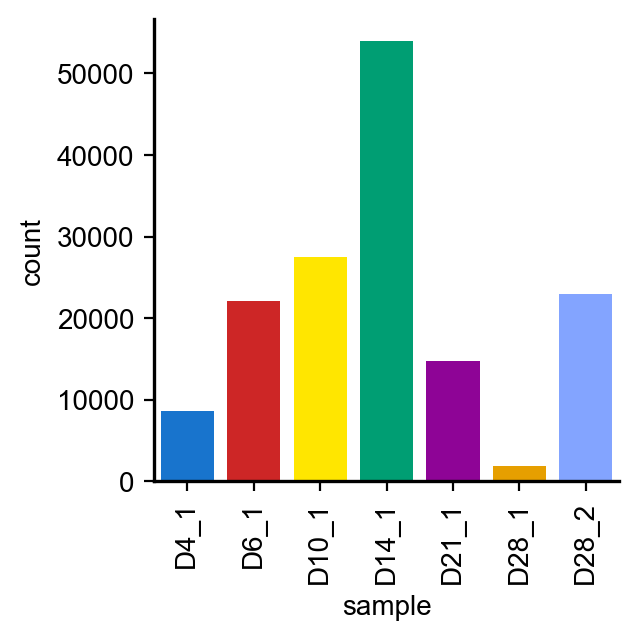

In [12]:
sns.countplot(data = adata.obs, x = "sample",hue = "sample",legend=False,saturation = 1)
plt.xticks(rotation = 90);

UMIs per cell per sample

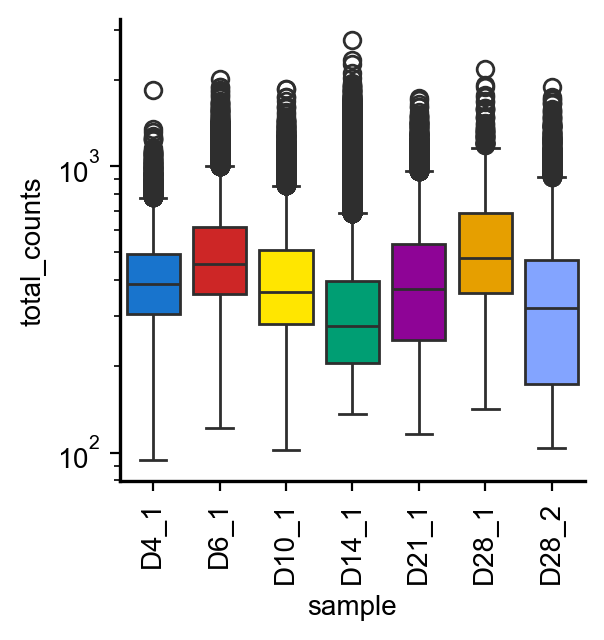

In [14]:
sns.boxplot(data = adata.obs, x = "sample", y = "total_counts",hue = "sample",legend=False,saturation = 1)
plt.yscale("log")
plt.xticks(rotation = 90);

GEX UMIs vs TS UMIs per sample

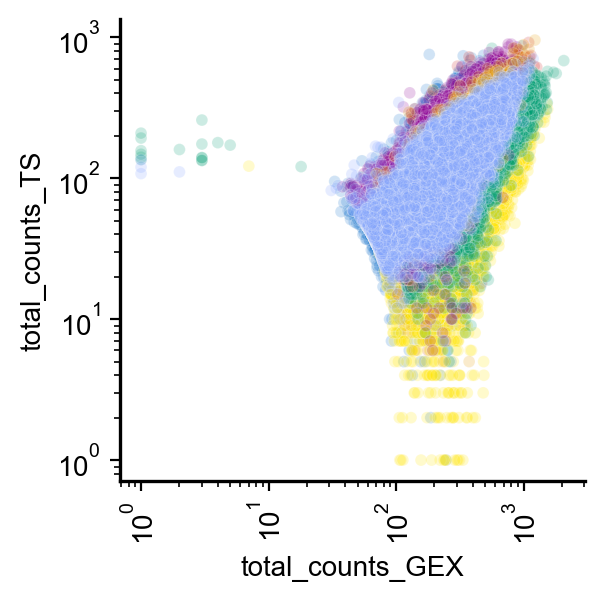

In [15]:
sns.scatterplot(data = adata.obs, x = "total_counts_GEX", y = "total_counts_TS",hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")
plt.yscale("log")
plt.xticks(rotation = 90);

## Low quality cells

In [16]:
adata.obs["type"] = "normal"
adata.obs["pct_counts_MT"] = adata.obs["total_counts_MT"]/adata.obs["total_counts_GEX"]*100

Cells with high mitochondrial content

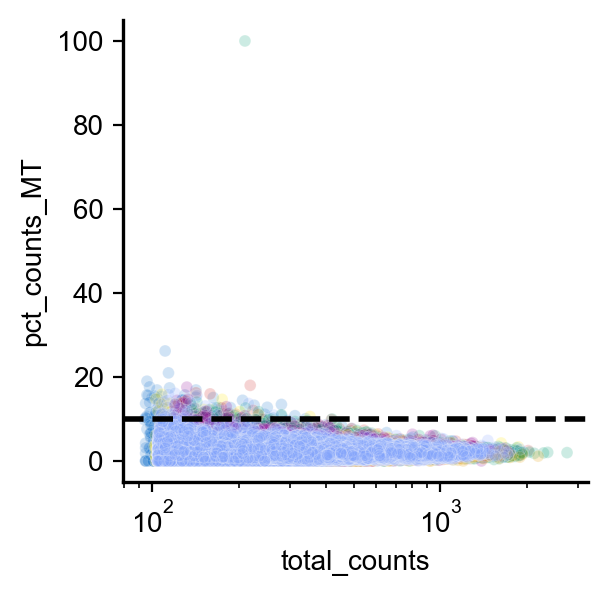

In [17]:
max_mt_pct = 10
adata.obs.loc[adata.obs["pct_counts_MT"] > max_mt_pct, "type"] = "high_mito"
sns.scatterplot(data = adata.obs, x = "total_counts", y = "pct_counts_MT",hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")
plt.axhline(y=max_mt_pct, color="black", linestyle="--")

Cells with too few UMIs

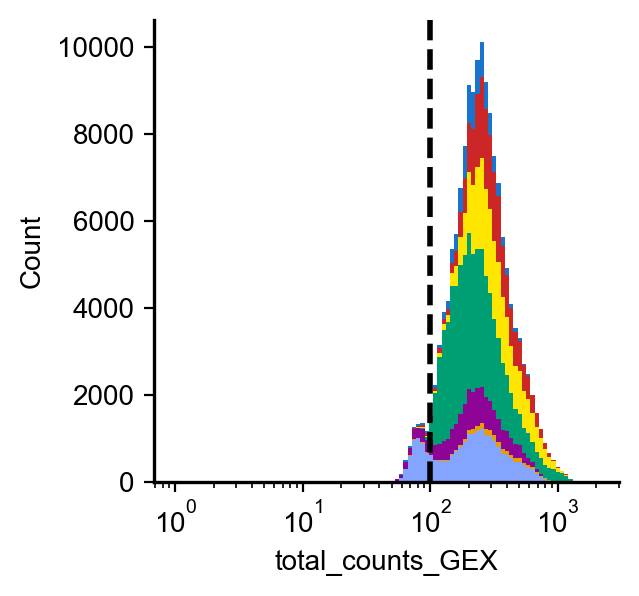

In [18]:
min_gex = 100
adata.obs.loc[adata.obs["total_counts_GEX"] < min_gex, "type"] = "low_umi"
sns.histplot(data = adata.obs, x = "total_counts_GEX", hue = "sample", bins = 100, log_scale = True,
              legend=False, multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=min_gex, color="black", linestyle="--")

Cell types

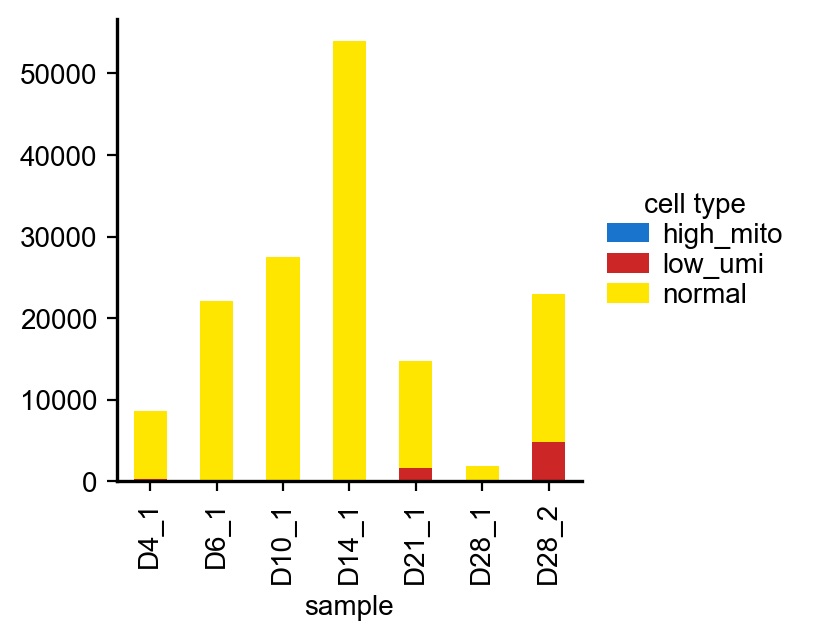

In [19]:
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Filter target site reads

In [20]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = alleles.query("cellBC.isin(@normal_cells) & UMI > 1").copy()
filtered_alleles["keep"] = True

Set minimum number of reads per UMI

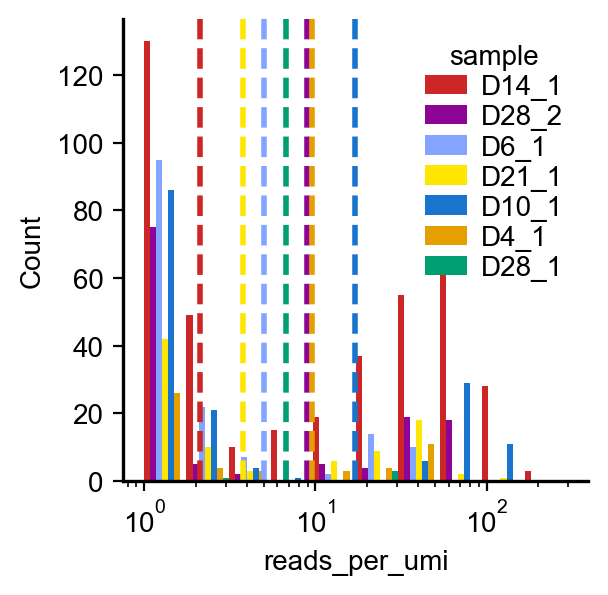

In [21]:
sample_colors = {sample:color for sample, color in zip(sorted(samples.values()),colors[1:])}
filtered_alleles["reads_per_umi"] = filtered_alleles["readCount"]/filtered_alleles["UMI"]
sns.histplot(data = filtered_alleles.sample(1000), x = "reads_per_umi", bins = 10,alpha = 1, 
             log_scale = True, hue = "sample", multiple="dodge",linewidth=0,palette=sample_colors)
for sample, sample_alleles in filtered_alleles.groupby("sample"):
    cutoff = sigma_threshold(sample_alleles["reads_per_umi"],log = True)
    filtered_alleles.loc[(filtered_alleles["sample"] == sample) & (filtered_alleles["reads_per_umi"] < cutoff),"keep"] = False
    plt.axvline(x=cutoff, linestyle="--",color = sample_colors[sample])

Set minimum number of UMIs per target site for each sample

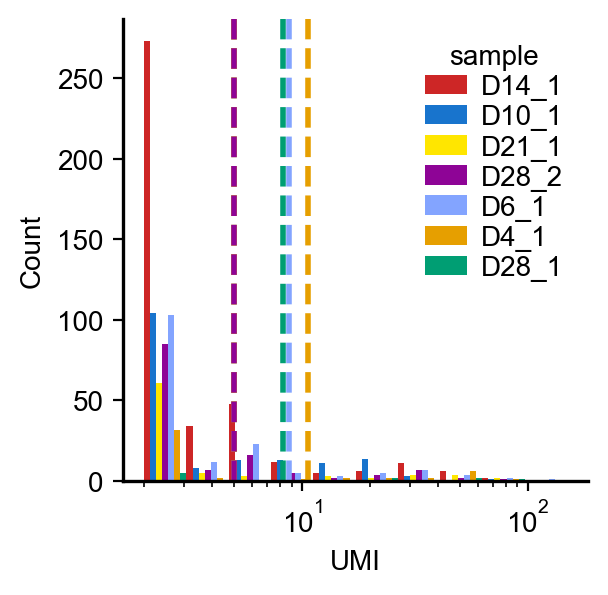

In [22]:
sns.histplot(data = filtered_alleles.sample(1000), x = "UMI", bins = 10,alpha = 1, 
             log_scale = True, hue = "sample", multiple="dodge",linewidth=0,palette=sample_colors)
for sample, sample_alleles in filtered_alleles.query("keep").groupby("sample"):
    cutoff = sigma_threshold(sample_alleles["UMI"],log = True)
    if cutoff < 5:
        cutoff = 5
    filtered_alleles.loc[(filtered_alleles["sample"] == sample) & (filtered_alleles["UMI"] < cutoff),"keep"] = False
    plt.axvline(x=cutoff, linestyle="--",color = sample_colors[sample])

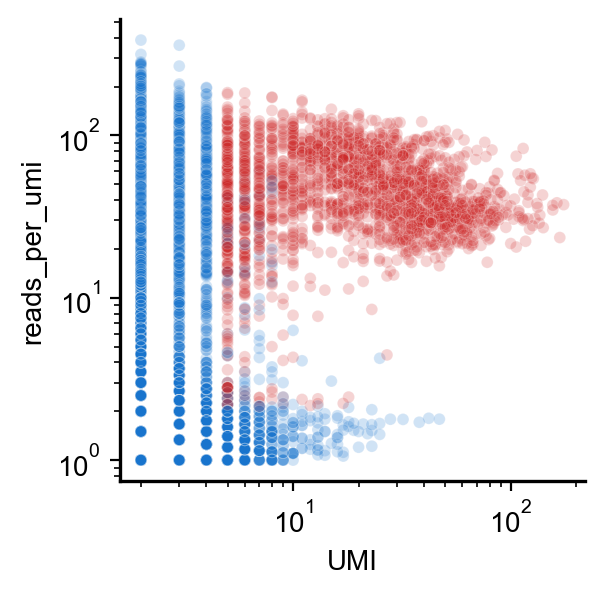

In [23]:
sns.scatterplot(data = filtered_alleles.sample(10000), x = "UMI", y = "reads_per_umi",
                hue = "keep",size = .1,alpha = .2,legend=False)
plt.yscale("log")
plt.xscale("log")

In [24]:
filtered_alleles = filtered_alleles.query("keep").drop(columns="keep").copy()

## Filter alleles

In [25]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = filtered_alleles.query("cellBC.isin(@normal_cells)").copy()

Remove alleles with < 20% of UMIs in a cell

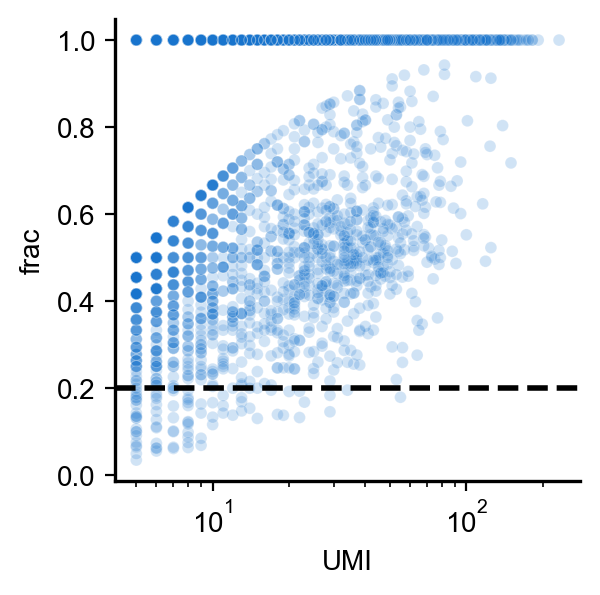

In [26]:
min_umi_frac = .2
filtered_alleles["frac"] = filtered_alleles["UMI"] / filtered_alleles.groupby(["cellBC", "intID"])["UMI"].transform("sum")
sns.scatterplot(filtered_alleles.sample(10000), x = "UMI",y = "frac",alpha = .2,size = .1,legend=False)
plt.xscale("log")
plt.axhline(y=min_umi_frac, color="black", linestyle="--")
filtered_alleles = filtered_alleles.query("frac > @min_umi_frac").copy()

Select allele with the most edits as long as the alleles differ by at most one edit

In [27]:
filtered_alleles["n_alleles"] = filtered_alleles.groupby(['intID', 'cellBC'])["intID"].transform("count")
selected_alleles = filtered_alleles[filtered_alleles.n_alleles == 2].groupby(['intID', 'cellBC']).apply(select_allele).reset_index(drop = True)
filtered_alleles = pd.concat([filtered_alleles[filtered_alleles.n_alleles != 2],selected_alleles])

/tmp/ipykernel_3875715/3876977017.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_alleles = filtered_alleles[filtered_alleles.n_alleles == 2].groupby(['intID', 'cellBC']).apply(select_allele).reset_index(drop = True)


Remove integrations with conflicts in >25% of UMIs

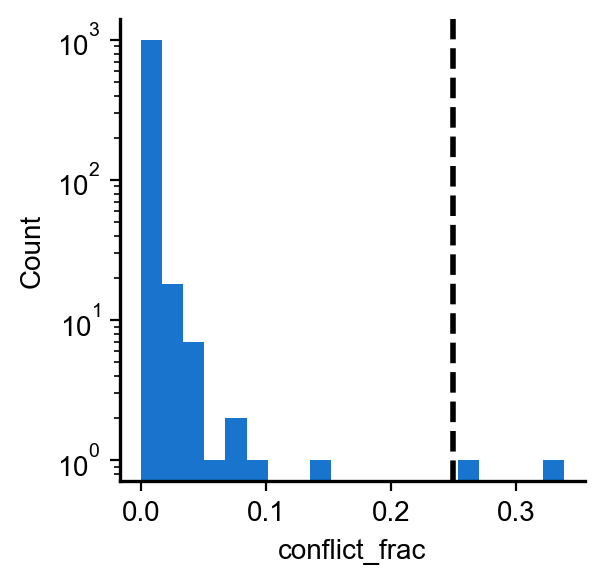

In [28]:
max_int_conflict = .25
int_conflicts = filtered_alleles[filtered_alleles.n_alleles > 1].groupby(["intID"])["UMI"].sum() / filtered_alleles.groupby(["intID"])["UMI"].sum()
int_conflicts = int_conflicts.reset_index().fillna(0).rename(columns = {"UMI":"conflict_frac"})
filtered_alleles = filtered_alleles.merge(int_conflicts, on = ["intID"]).query(
    "conflict_frac < @max_int_conflict ").copy().drop(columns = "conflict_frac")
sns.histplot(int_conflicts, x = "conflict_frac",bins = 20,multiple="stack",linewidth=0,alpha = 1,log = True)
plt.axvline(x=max_int_conflict, color="black", linestyle="--")

Mark cells with conflicts in >25% of integration UMIs as doublets

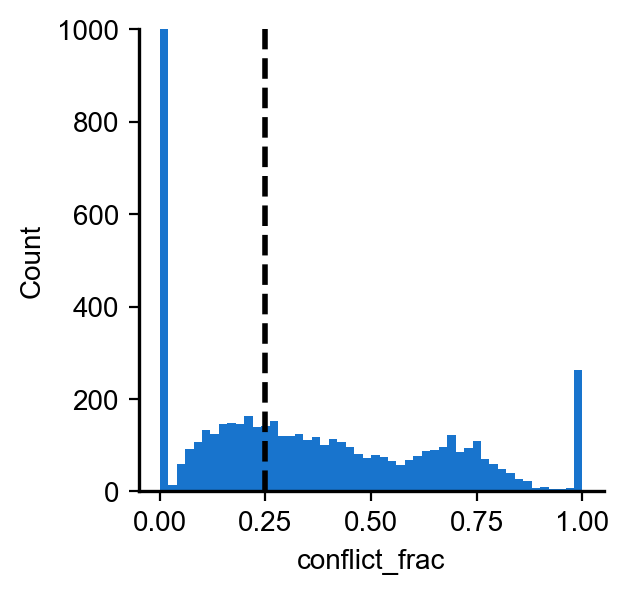

In [29]:
max_cell_conflict = .25
cell_conflicts = filtered_alleles[filtered_alleles.n_alleles > 1].groupby(["cellBC"])["UMI"].sum() / filtered_alleles.groupby(["cellBC"])["UMI"].sum()
cell_conflicts = cell_conflicts.reset_index().fillna(0).rename(columns = {"UMI":"conflict_frac"})
sns.histplot(cell_conflicts, x = "conflict_frac",bins = 50,multiple = "stack",linewidth=0,alpha = 1)
plt.ylim(0,1000)
plt.axvline(x=max_cell_conflict, color="black", linestyle="--")
doublets = cell_conflicts.query("conflict_frac > @max_cell_conflict")["cellBC"]

Resolve remaining conflict by selecting allele with most UMIs

In [30]:
filtered_alleles = filtered_alleles[~filtered_alleles.cellBC.isin(doublets)].copy()
filtered_alleles = filtered_alleles.sort_values("frac",ascending = False).groupby(
    ["intID","cellBC"]).first().reset_index().drop(columns = ["frac","n_alleles"])

Mark doublets

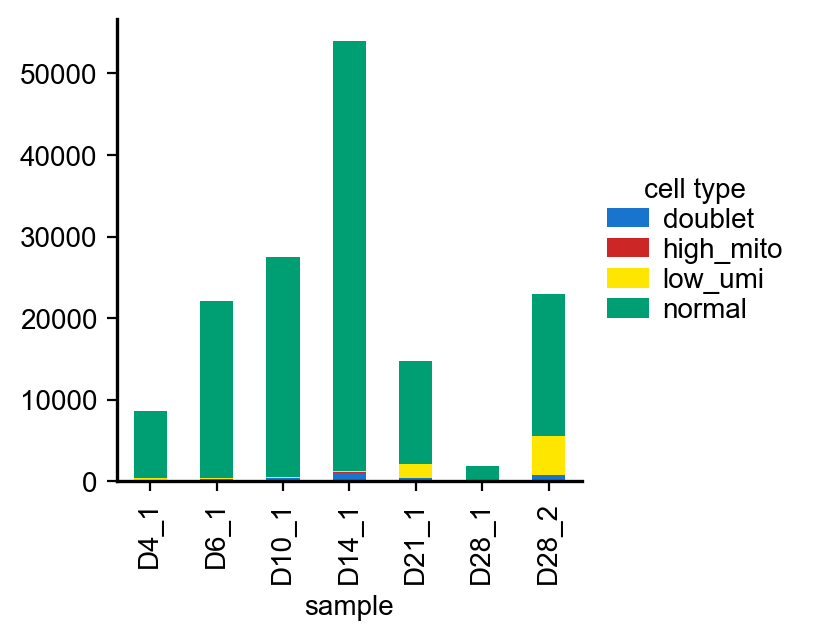

In [31]:
adata.obs.loc[doublets, "type"] = "doublet"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Allele statistics

Edit fraction

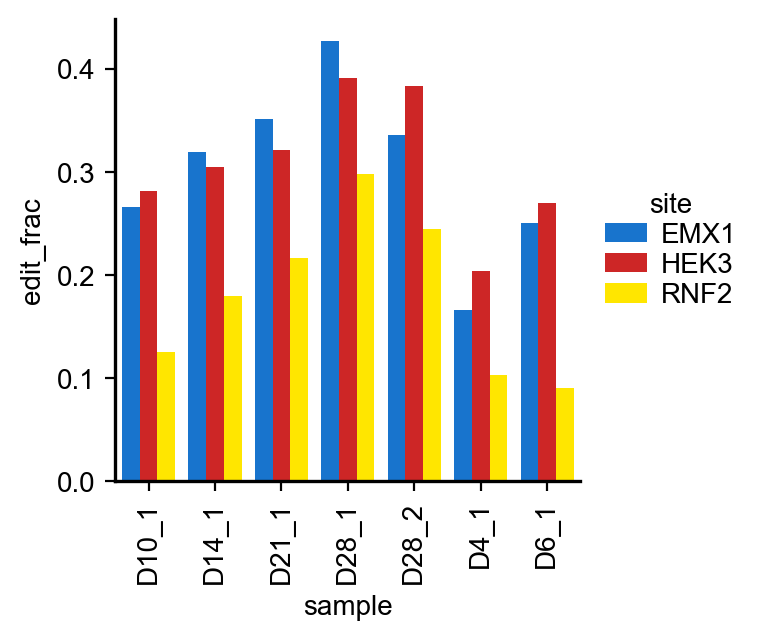

In [32]:
edit_counts = filtered_alleles[site_names + ['UMI',"cellBC","intID","sample"]].melt(
    id_vars = ["cellBC","UMI","intID","sample"],value_name="edit", var_name="site")
edit_frac = edit_counts.query("edit != 'None'").groupby(["sample","intID","site"]).size()/ \
    edit_counts.groupby(["sample","intID","site"]).size()
edit_frac = edit_frac.reset_index(name = "edit_frac").groupby(["site","sample"]).agg({"edit_frac":"mean"}).reset_index()
sns.barplot(data = edit_frac,y = "edit_frac",x = "sample",hue = "site",saturation=1)
plt.legend(loc='center left', title='site', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation = 90);

Edit frequency

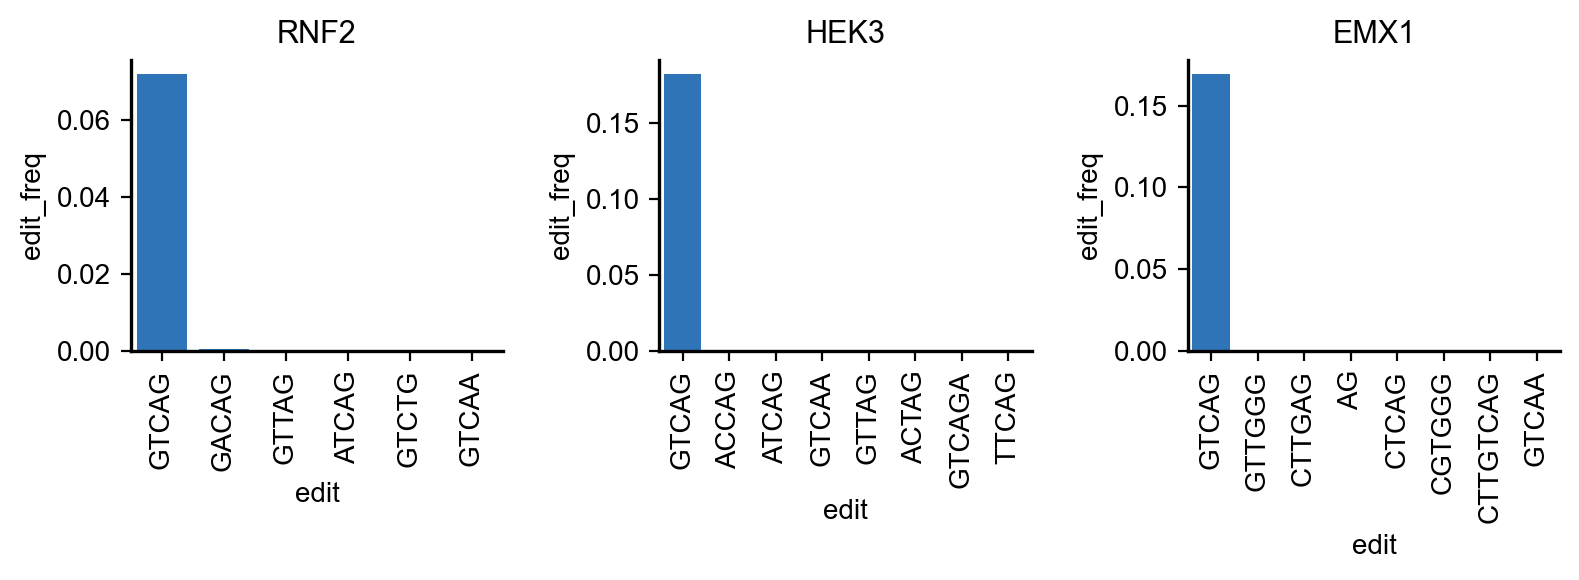

In [34]:
edit_frequency =  edit_counts.groupby(["site","edit"]).size() / edit_counts.groupby(["site"]).size()
edit_frequency = edit_frequency.reset_index(name = "edit_freq")
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, site in enumerate(site_names):
    sns.barplot(
        data=edit_frequency.query(f"site == '{site}' & edit != 'None'").sort_values("edit_freq", ascending=False).head(8),
        x="edit",y="edit_freq", ax=axes[i])
    axes[i].set_title(site)
    plt.setp(axes[i].get_xticklabels(), rotation=90)
plt.tight_layout()

## Call guides

Load data

In [411]:
guides = []
for sample, name in samples.items():
    sample_guides = pd.read_csv(data_path / sample / f"{sample}_crispr_analysis/protospacer_calls_per_cell.csv")
    sample_guides["sample"] = name
    sample_guides["cellBC"] = (name + "-" + sample_guides["cell_barcode"])
    guides.append(sample_guides)
guides = pd.concat(guides)
guides["feature_call"] = guides['feature_call'].str.split('|')
guides["UMI"] = guides['num_umis'].str.split('|')
guides = guides.explode(["feature_call","UMI"])
guides["UMI"] = guides["UMI"].astype(int)

Extract info

In [412]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_guides = guides.query("cellBC.isin(@normal_cells)").copy()
filtered_guides["peg"] = filtered_guides["feature_call"].str.replace("mut_","").str.split("_").str[1]
filtered_guides["peg_site"] = filtered_guides["feature_call"].str.split("_").str[0]
filtered_guides["day"] = filtered_guides["sample"].str.split("_").str[0].str.replace("D","").astype(int)

Set UMI threshold

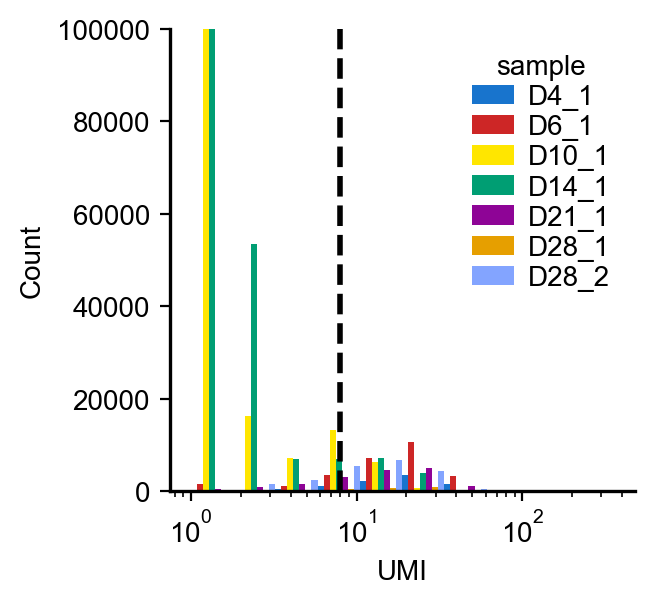

In [413]:
min_umi = 8
sns.histplot(filtered_guides, x = "UMI",hue = "sample",bins = 10,multiple="dodge",linewidth=0,alpha = 1,log_scale = True)
plt.ylim(0,1e5)
plt.axvline(x=min_umi, color="black", linestyle="--")

Identify doublets using guides

In [414]:
filtered_guides = filtered_guides.query("UMI > 2").copy()
filtered_guides["n_guides"] = filtered_guides.groupby(['cellBC'])["peg"].transform("size")
filtered_guides = filtered_guides.query("UMI > @min_umi").copy()
doublets = filtered_guides.query("n_guides > 1").cellBC.unique()
filtered_guides = filtered_guides.query("~cellBC.isin(@doublets)").copy()
no_guide = list(set(adata.obs.query("type == 'normal'").index) - set(filtered_guides.cellBC))
adata.obs.loc[no_guide, "type"] = "no_guide"
adata.obs.loc[doublets, "type"] = "doublet"

Identify doublets using alleles

In [415]:
for site in site_names:
    filtered_alleles[f"{site}_edited"] = filtered_alleles[site] != "None"
n_edited = filtered_alleles.groupby(["cellBC","intID"]).agg({f"{site}_edited":"sum" for site in site_names}).reset_index()
n_edited["n_edited"] = n_edited[[f"{site}_edited" for site in site_names]].sum(axis = 1)
doublets = n_edited.query("n_edited > 1")["cellBC"]
adata.obs.loc[doublets, "type"] = "doublet"
filtered_guides = filtered_guides.query("~cellBC.isin(@doublets)").copy()

Peg coverage

<Axes: xlabel='day', ylabel='peg_site-peg'>

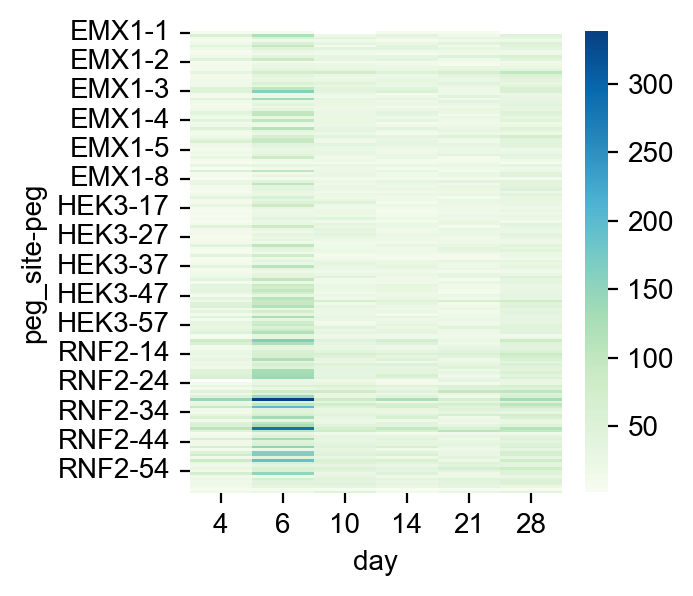

In [416]:
filtered_guides["n_cells"] = filtered_guides.groupby(["peg","peg_site","day"])["cellBC"].transform("nunique")
peg_counts = filtered_guides.groupby(["peg","peg_site","day"]).agg({"n_cells":"first"}).reset_index()
sns.heatmap(peg_counts.pivot_table(index = ["peg_site","peg"],columns = "day",values = "n_cells",fill_value = 0),cmap = sequential_cmap) 

Cell types

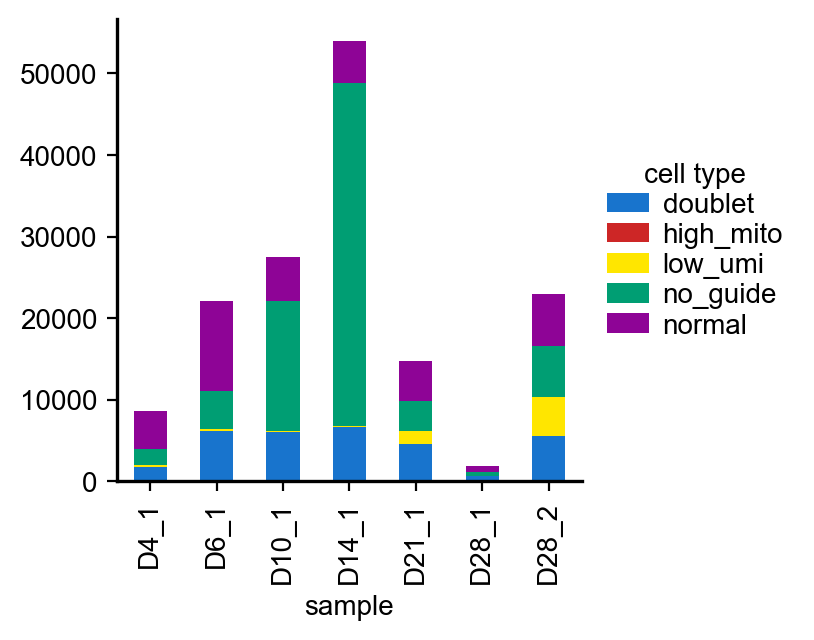

In [417]:
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

In [418]:
normal_cells = adata.obs.query("type == 'normal'").cellBC.unique()
filtered_guides = filtered_guides.query("cellBC.isin(@normal_cells)").copy()
adata.obs = adata.obs.merge(filtered_guides[["cellBC","peg","peg_site","n_cells"]], on = "cellBC", how = "left")
adata.obs["day"] = adata.obs["sample"].str.split("_").str[0].str.replace("D","").astype(int)
filtered_alleles = filtered_alleles.merge(adata.obs[["cellBC","type","peg","peg_site","day","n_cells"]], on = "cellBC", how = "left")
filtered_alleles = filtered_alleles.query("cellBC.isin(@normal_cells)").copy()

## Calculate edit fraction

Get edit fraction

<Axes: xlabel='edit_frac', ylabel='Count'>

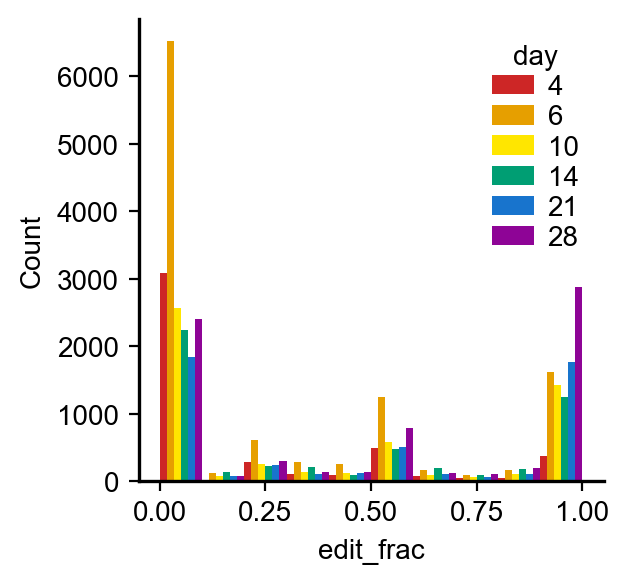

In [419]:
adata.obs.index = adata.obs["cellBC"].values
filtered_alleles["edited"] = filtered_alleles.apply(lambda x: x[x["peg_site"]] != "None", axis = 1)
edit_frac = filtered_alleles.groupby(["cellBC"]).agg({"edited":"mean"})["edited"]
adata.obs["edit_frac"] = edit_frac
sns.histplot(data = adata.obs, x = "edit_frac",hue = "day",bins = 10,multiple="dodge",linewidth=0,alpha = 1,palette = discrete_cmap[6])

Get number of integrations

<Axes: xlabel='n_int', ylabel='Count'>

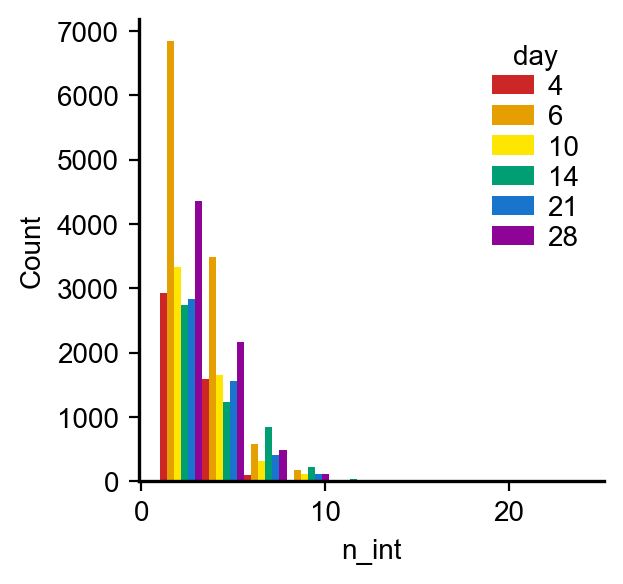

In [420]:
n_int = filtered_alleles.groupby(["cellBC"])["intID"].nunique()
adata.obs["n_int"] = n_int
sns.histplot(data = adata.obs, x = "n_int",hue = "day",bins = 10,multiple="dodge",linewidth=0,alpha = 1,palette = discrete_cmap[6])

## Write data

In [421]:
name = "B16F10"
filtered_adata = adata[adata.obs.query("type == 'normal'").index].copy()
filtered_adata.obs.drop(columns = ["total_counts_MT","pct_counts_MT","total_counts_TS","pct_counts_TS","total_counts_GEX","pct_counts_GEX"],inplace = True)
filtered_adata.write(data_path / f"{name}_kinetics.h5ad")
filtered_adata.obs.to_csv(data_path / f"{name}_kinetics_cells.csv",index = False)
filtered_alleles.to_csv(data_path / f"{name}_kinetics_alleles.csv",index = False)